# `strymread` tutorial
## Analyzing CAN data logged from Giraffee and Panda

### Prerequisite
- Install strym package from git: `pip install git+https://github.com/jmscslgroup/strym.git`
A detailed instruction about installation is available at https://github.com/jmscslgroup/strym/blob/master/README.md

In [1]:
import strym
from strym import strymread
from strym import ranalyze
import matplotlib.pyplot as plt
import pandas as pd
from pylab import rcParams
import strym.DBC_Read_Tools as dbc
import numpy as np
from scipy.interpolate import interp1d
rcParams.update({'font.size': 40})
dbcfile = '/home/ivory/VersionControl/Jmscslgroup/strym/examples/newToyotacode.dbc'
r =strymread(csvfile="/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_02_18/2020-02-18-13-00-42-209119__CAN_Messages.csv", dbcfile=dbcfile)


## We will visualize the counts of all messages
The plot is split into several subplots for brevity.

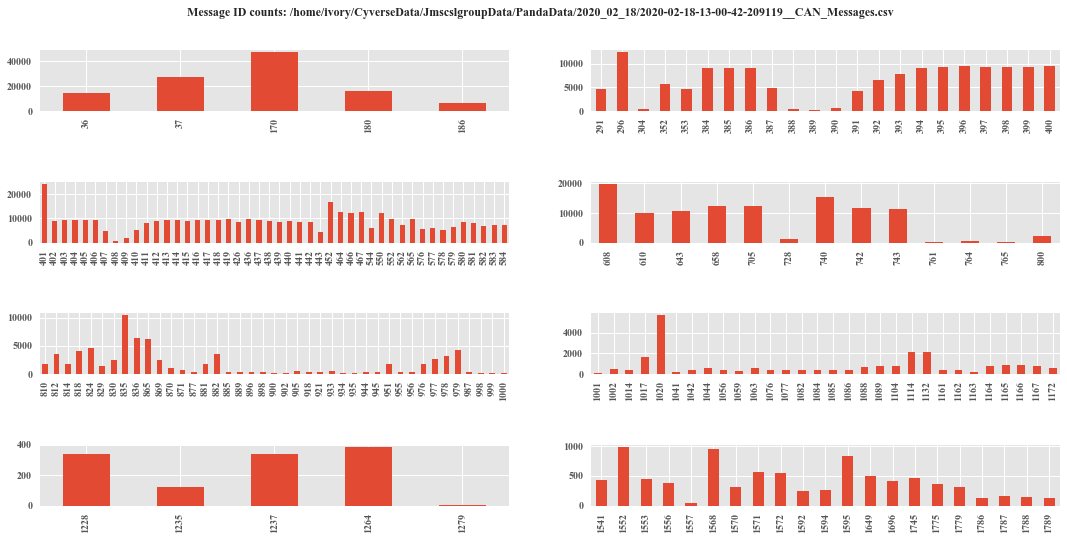

In [2]:
r.count()

## Let's plot a few important data
### Speed

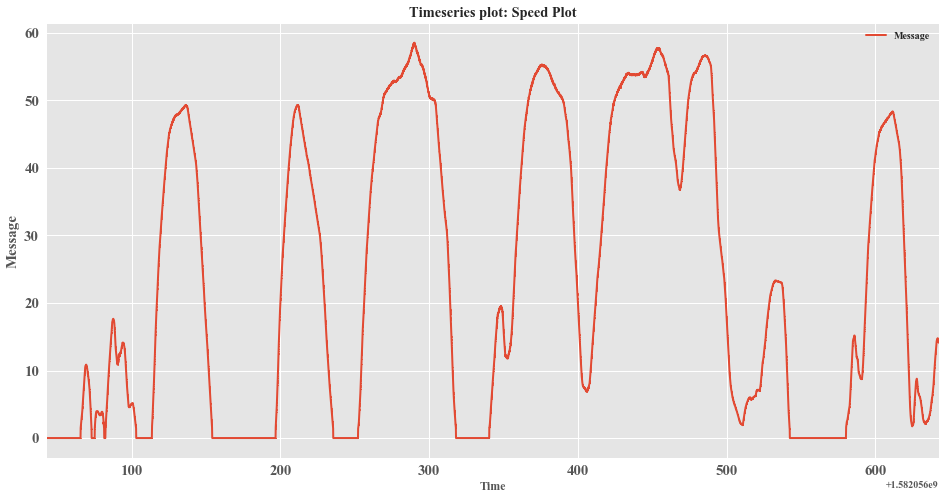

In [3]:
speed = r.speed()
strym.plt_ts(speed, title="Speed Plot")

## Rate Statistics for every message ID

In [4]:
u = r.frequency()
u

,MessageID,MeanRate,MedianRate,RateStd,MaxRate,MinRate,RateIQR
0,36,32.260922,25.072279,15.360394,53.850452,3.334333,33.153221
1,37,32.260922,25.072279,15.360394,53.850452,3.334333,33.153221
2,170,32.260922,25.072279,15.360394,53.850452,3.334333,33.153221
3,180,32.260922,25.072279,15.360394,53.850452,3.334333,33.153221
4,186,32.260922,25.072279,15.360394,53.850452,3.334333,33.153221
...,...,...,...,...,...,...,...
178,1779,32.260922,25.072279,15.360394,53.850452,3.334333,33.153221
179,1786,32.260922,25.072279,15.360394,53.850452,3.334333,33.153221
180,1787,32.260922,25.072279,15.360394,53.850452,3.334333,33.153221
181,1788,32.260922,25.072279,15.360394,53.850452,3.334333,33.153221


In [5]:
## Synchronize Two Time Series messages and resample with a fixed datarate

In [6]:
dbcfile = '/home/ivory/VersionControl/Jmscslgroup/strym/examples/newToyotacode.dbc'
r =strymread(csvfile="/home/ivory/CyverseData/JmscslgroupData/PandaData/2020_02_18/2020-02-18-13-00-42-209119__CAN_Messages.csv", dbcfile=dbcfile)


It means first time of speed is earlier than yaw in time-series data so we have to interpolate speed value at yaw's first time. We will use linear interpolation.

Linear interpolation formula is 

$$
X_i = \cfrac{X_A - X_B}{a-b}(i-b) + X_B
$$

In [17]:

# Available in strymread via `strym.ts_sync`
def ts_sync(df1, df2, rate=50):
    '''
    Time-synchronize and resample two time-series dataframes of varying, non-uniform sampling.
    
    In a non-ideal condition, the first time of `df1` timeseries dataframe will not be same as
    the first time of `df2` dataframe.
    
    In that case, we will calculate the value of message at the latest of two first times of `df1`
    and `df2` using linear interpolation method. Call the latest of two first time as `latest_first_time`.
    
    Similarly, we will calculate the value of message at the earliest of two end times of `df1`
    and `df2` using linear interpolation method. Call the latest of two first time as `earliest_last_time`.
    
    Linear interpolation formula is 

    $$
    X_i = \cfrac{X_A - X_B}{a-b}(i-b) + X_B
    $$


    Next, we will truncate anything beyond [`latest_first_time`, `earliest_last_time`]
    
    Once we have common first and last time in both timeseries dataframes, we will use cubic interpolation 
    to do uniform sampling and interpolation of both time-series dataframe.
    
    Parameters
    -----------
    df1: `pandas.DataFrame`
        First timeseries datframe. First column name must be named 'Time' and second column must be 'Message'
    
    df2: `pandas.DataFrame`
        Second timeseries datframe. First column name must be named 'Time' and second column must be 'Message'
        
    rate: `double`
        New uniform sampling rate
        
    
    Returns
    -------
    
    dfnew1: `pandas.DataFrame`
        First new resampled timseries DataFrame
    
    dfnew2: `pandas.DataFrame`
        Second new resampled timseries DataFrame
    
    
    '''
    if df1['Time'].iloc[0] < df2['Time'].iloc[0]:
        # It means first time of df1 is earlier than df2 in time-series data
        # so we have to interpolate speed value at df2's first time.
        # we will use linear interpolation
        # find a next time on df1's axis that is greater than df2's first time
        tempdf = df1[df1['Time'] > df2['Time'].iloc[0]]
        timenext = tempdf['Time'].iloc[0]
        valuenext = tempdf['Message'].iloc[0]
        interpol = (df1['Message'].iloc[0] - valuenext)/(df1['Time'].iloc[0] - timenext )*(df2['Time'].iloc[0] - timenext) + valuenext
        df1 = df1.append({'Time' : df2['Time'].iloc[0] , 'Message' : interpol} , ignore_index=True)
    elif df1['Time'].iloc[0] > df2['Time'].iloc[0]:
        # It means first time of df2 is earlier than df1 in time-truncated data
        # so we have to interpolate message value at df1's first time.
        # we will use linear interpolation
        # find a next time on df2's axis that is greater thandf1's first time
        tempdf = df2[df2['Time'] > df1['Time'].iloc[0]]
        timenext = tempdf['Time'].iloc[0]
        valuenext = tempdf['Message'].iloc[0]
        interpol = (df2['Message'].iloc[0] - valuenext)/(df2['Time'].iloc[0] - timenext )*(df1['Time'].iloc[0] - timenext) + valuenext
        df2 = df2.append({'Time' : df1['Time'].iloc[0] , 'Message' : interpol} , ignore_index=True)
    
    df1= df1.sort_values(by=['Time'])
    df2= df2.sort_values(by=['Time'])
    
    if df1['Time'].iloc[-1] < df2['Time'].iloc[-1]:
        # It means last time of df1 is earlier than df2 in time-series data
        # so we have to interpolate df2 value at df1's last time.
        # we will use linear interpolation
        # find a time before on df2's axis that is less than df1's last time
        tempdf = df2[df2['Time'] < df1['Time'].iloc[-1]]
        timefirst = tempdf['Time'].iloc[-1]
        valuefirst = tempdf['Message'].iloc[-1]
        interpol = (valuefirst - df2['Message'].iloc[-1])/(timefirst - df2['Time'].iloc[-1])*(timefirst - df1['Time'].iloc[-1]) + df2['Message'].iloc[-1]
        df2 = df2.append({'Time' : df1['Time'].iloc[-1] , 'Message' : interpol} , ignore_index=True)
    elif df1['Time'].iloc[-1] > df2['Time'].iloc[-1]:
        # It means last time of df2 is earlier than df1 in time-series data
        # so we have to interpolate df1 value at df2's last time.
        # we will use linear interpolation
        # find a next time on df1's axis that is less than df2's last time
        tempdf = df1[df1['Time'] < df2['Time'].iloc[-1]]
        timefirst = tempdf['Time'].iloc[-1]
        valuefirst = tempdf['Message'].iloc[-1]
        interpol = (valuefirst- df1['Message'].iloc[-1] )/(timefirst - df1['Time'].iloc[-1])*(timefirst - df2['Time'].iloc[-1]) + df1['Message'].iloc[-1]
        df1 = df1.append({'Time' : df2['Time'].iloc[-1] , 'Message' : interpol} , ignore_index=True)
        
    df1= df1.sort_values(by=['Time'])
    df2= df2.sort_values(by=['Time'])
    ## Truncate.
    if df1['Time'].iloc[0] < df2['Time'].iloc[0]:
        df1 = df1.drop(df1.index[0])
    elif df1['Time'].iloc[0] > df2['Time'].iloc[0]:
        df2 = df2.drop(df2.index[0])
        
    # truncate
    if df1['Time'].iloc[-1] < df2['Time'].iloc[-1]:
        df2 = df2.drop(df2.index[-1])
    elif df1['Time'].iloc[-1] > df2['Time'].iloc[-1]:
        df1 = df1.drop(df1.index[-1])
        
    # divide time-axis equal as per given rate
    df1t0 = df1['Time'].iloc[0]
    df1tend = df1['Time'].iloc[-1]
    n = (df1tend - df1t0)*rate
    t_newdf1 = np.linspace(df1t0, df1tend, num=n)
    
    # divide time-axis equal as per given rate
    df2t0 = df2['Time'].iloc[0]
    df2tend = df2['Time'].iloc[-1]
    n = (df2tend - df2t0)*rate
    t_newdf2 = np.linspace(df2t0, df2tend, num=n)
    
    # Interpolate function using cubic method
    f1 = interp1d(df1['Time'].values,df1['Message'], kind = 'cubic')
    newvalue1 = f1(t_newdf1)
    
    # Interpolate function using cubic method
    f2 = interp1d(df2['Time'].values,df2['Message'], kind = 'cubic')
    newvalue2 = f2(t_newdf2)
    
    dfnew1 = pd.DataFrame()
    dfnew1['Time'] = t_newdf1
    dfnew1['Message'] = newvalue1
    
    dfnew2 = pd.DataFrame()
    dfnew2['Time'] = t_newdf2
    dfnew2['Message'] = newvalue2
    
    return dfnew1, dfnew2

In [8]:
ts_yaw_rate = r.yaw_rate()
ts_speed = r.speed()

# integrate yaw rate to get the heading
ts_yaw = r.integrate(ts_yaw_rate)

In [9]:
new1, new2 = ts_sync(ts_speed, ts_yaw)

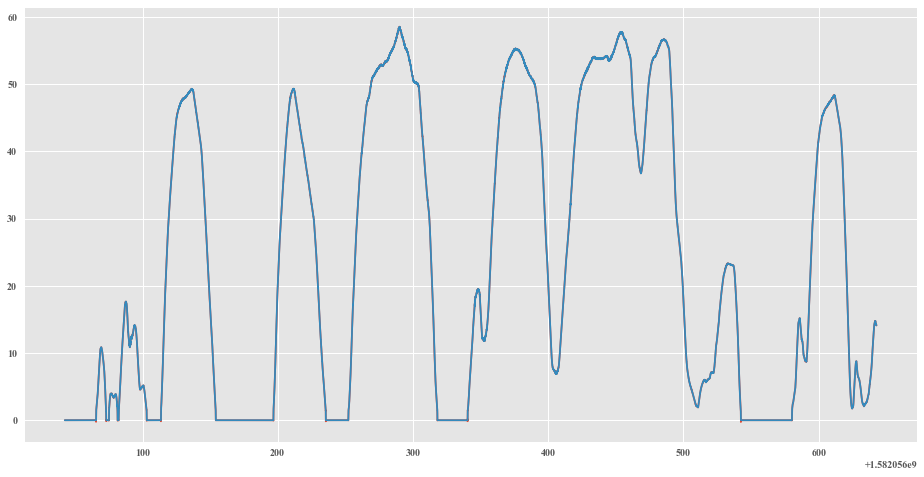

In [12]:
plt.plot(new1['Time'], new1['Message'])
plt.plot(ts_speed['Time'], ts_speed['Message'])

(1582056042.5240324, 1582056129.5470471)

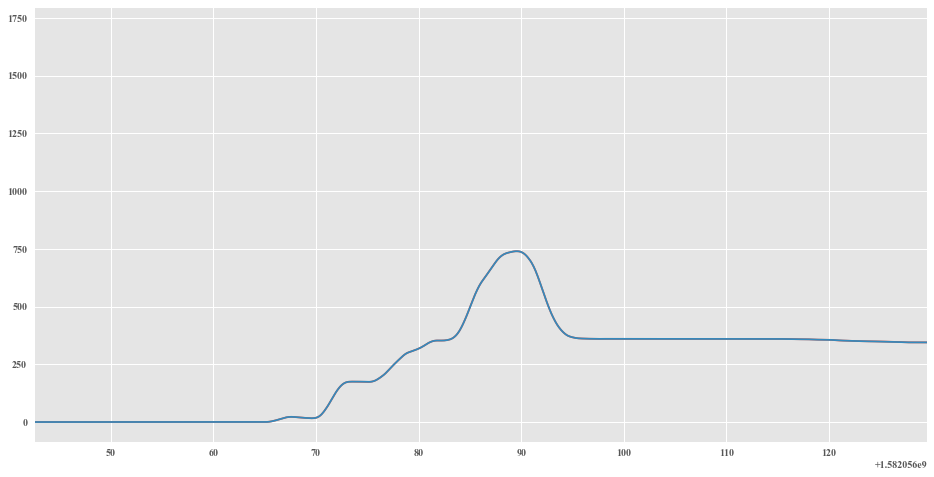

In [13]:
plt.plot(new2['Time'], new2['Message'])
plt.plot(ts_yaw['Time'], ts_yaw['Message'])
plt.xlim([ts_yaw['Time'].iloc[0], ts_yaw['Time'].iloc[2333]])

In [14]:
T = r.trajectory()

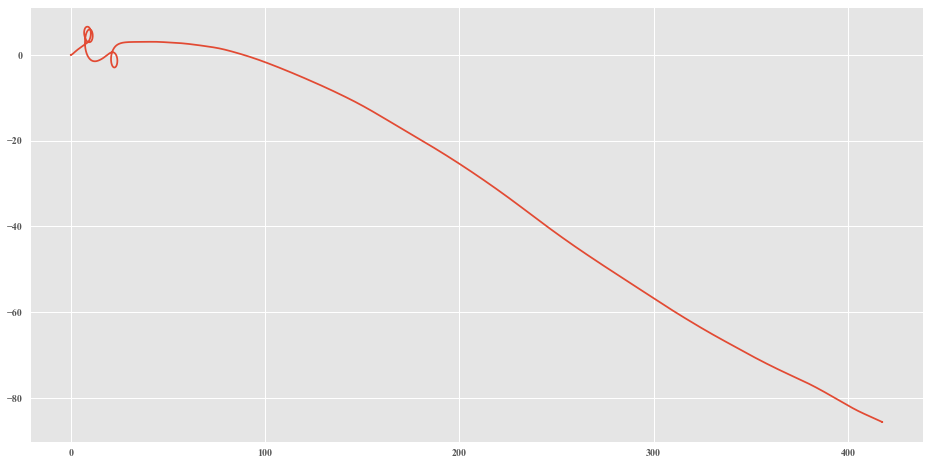

In [15]:
plt.plot(T['X'].iloc[1:7501], T['Y'].iloc[1:7501])

In [16]:
T[1:7500]

,Time,X,Y,Vx,Vy
1,1.582056e+09,0.000000,0.000000,0.000000e+00,0.000000e+00
2,1.582056e+09,0.000000,0.000000,0.000000e+00,0.000000e+00
3,1.582056e+09,0.000000,0.000000,0.000000e+00,0.000000e+00
4,1.582056e+09,0.000000,0.000000,0.000000e+00,0.000000e+00
5,1.582056e+09,0.000000,0.000000,0.000000e+00,0.000000e+00
...,...,...,...,...,...
7495,1.582056e+09,417.701559,-85.615588,-4.406514e-79,9.035949e-80
7496,1.582056e+09,417.701559,-85.615588,8.306864e-79,-1.703396e-79
7497,1.582056e+09,417.701559,-85.615588,-2.992949e-78,6.137309e-79
7498,1.582056e+09,417.701559,-85.615588,1.100858e-77,-2.257407e-78


In [18]:
strym.ts_sync

<function strym.strymread.ts_sync(df1, df2, rate=50)>